## tensor
tensor是pytorch中最基本的部分，因为要计算模型训练和推理的时间，就要计算单位加法和乘法的次数，而这个次数是由tensor和数据类型决定的，因为tensor存储parameters, gradients, optimizer state, data, activations.

In [ ]:
# 创建tensor的几种方法
x = torch.tensor([[1., 2, 3], [4, 5, 6]])  # @inspect x
x = torch.zeros(4, 8)  # 4x8 matrix of all zeros @inspect x
x = torch.ones(4, 8)  # 4x8 matrix of all ones @inspect x
x = torch.randn(4, 8)  # 4x8 matrix of iid Normal(0, 1) samples @inspect x

#### 浮点数的类型
##### float 32
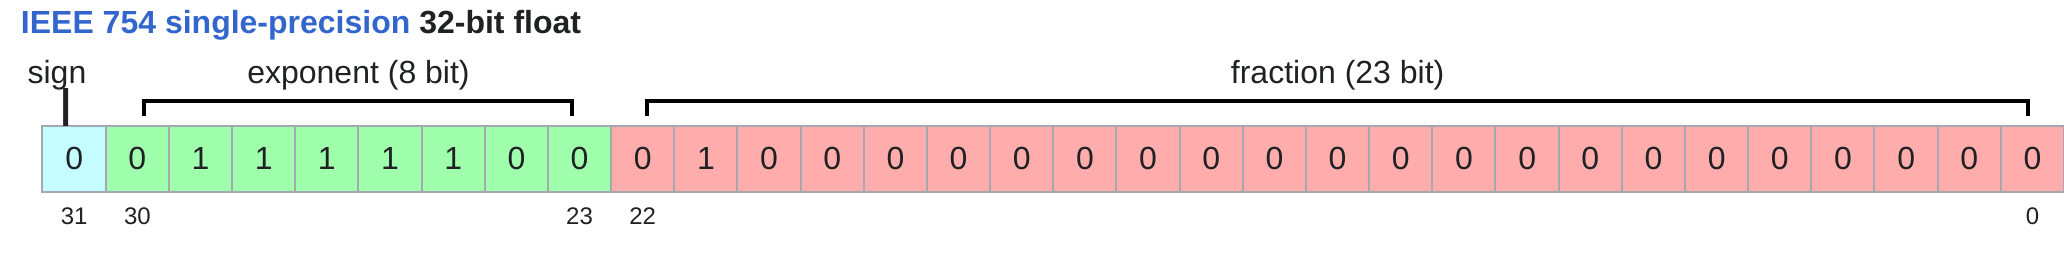
f32是默认的数据类型，精度比较高，占内存4byte

##### float16
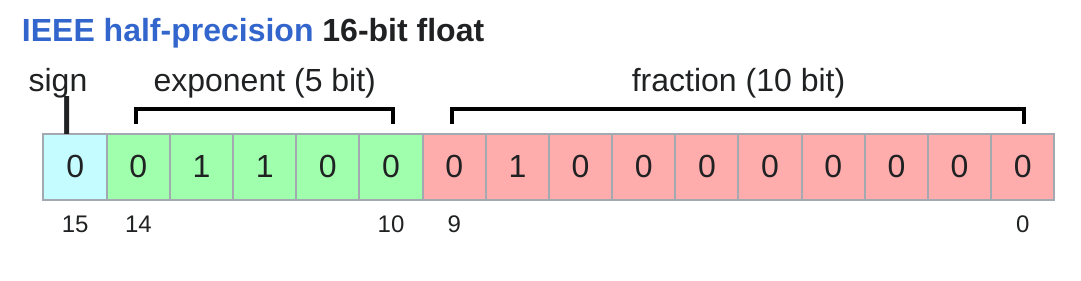
f16占内存2byte,会出现underflow的问题（非常小的数会被认定为0）

##### bfloat16
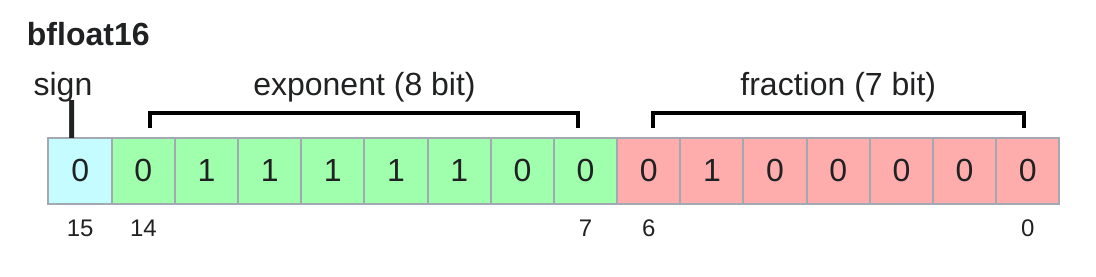
与f16占内存一样大，都是2个byte，但是与f32能够表示的数值范围一样，不过精度没有f32高

##### fp8
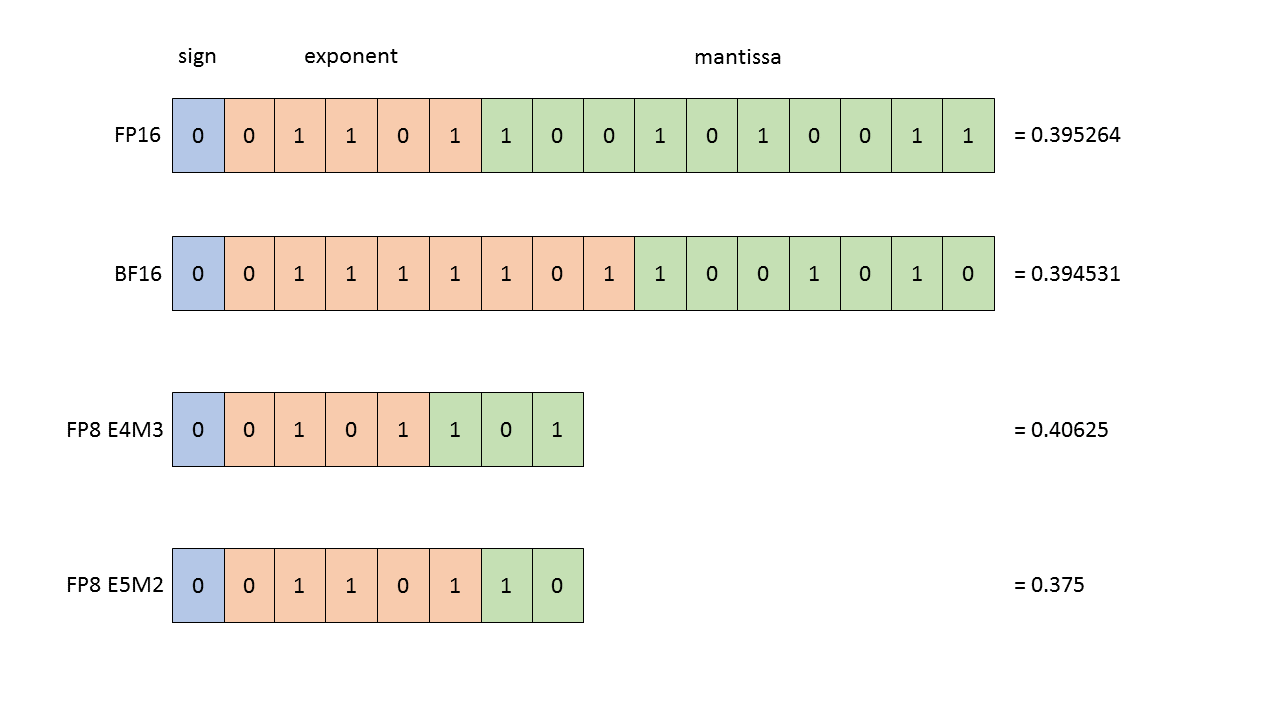


#### 使用浮点数的不同情况
 - 如果需要继续计算，那么精度会积累，此时就要用f32
 - 如果这个模型已经训练好了，要用于infer,那么此时可以把它变成bf16